### Model family graph visualization
Here is an example to create a model family using Alexnet layers and display the results in a graph

In [2]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import rsatoolbox
from rsatoolbox.model import ModelFamily

### Load model RDMs
Here the models are different layers of Alexnet.
For each layer, different models of how the fMRI voxels sample the neurons are being considered.

The simulated data were generated in Matlab (Kriegeskorte & Diedrichsen 2016). Thus, we load the Matlab files in .mat format.

For each model-RDM, we obtain the RDM itself, a model name, and a measurement model name. The model name specifies the layer used to generate the RDM. The measurement model name specifies the applied distortions.

In [4]:
matlab_data = io.matlab.loadmat('rdms_inferring/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])
model_rdms = rsa.rdm.RDMs(
    rdms_array,
    rdm_descriptors={'brain_computational_model':model_names,
                     'measurement_model':measurement_model},
                     dissimilarity_measure='Euclidean'
    )

rsa.vis.show_rdm(model_rdms)

NameError: name 'rsa' is not defined

### Load and choose data RDMs
We use again simulated data to demonstrate RSA inference.

The chosen ground truth model is:
conv3
with noise level:
3.0
with averaging width (full width at half magnitude):
0.0


### Define fixed models
An "RDM model" is a pyRSA object that can predict a data RDM.
For example, a flexible RDM model may contain a set of predictor RDMs, which predict the data RDM as a weighted combination.
Here we use fixed RDM models, which contain just a single RDM with no parameters to be fitted.

Models are generated by first choosing the RDM, in this case the one with the right "brain_computational_model" and the "measurement_model" "complete", which corresponds to no distortions added. This object is then passed to the function `pyrsa.model.ModelFixed`, which generates a fixed RDM model. These RDM models are then collected in the list `models`. 

In [4]:
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','smooth1rpwavgFeat')
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)

/Users/heiko/opt/anaconda3/envs/rsa/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/heiko/opt/anaconda3/envs/rsa/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


### Crossvalidation
As a first step, we split our data into training and test sets, which should not share either subjects or stimuli. To do so, we split each dimension into k groups and leave one of these groups out as a testset and use all others as training data. Models choose their parameters to maximize performance on the training set and are evaluated on the test set. Additionally a so-called *ceil set* is created, which contains the data from the training subjects for the test stimuli, which is necessary for calculating a noise ceiling.

The variables `k_pattern` and `k_rdm` specify how many folds should be formed over stimuli and subjects, respectively.

In [5]:
train_set, test_set, ceil_set = rsatoolbox.inference.sets_k_fold(rdms_data, k_pattern=2, k_rdm=6,pattern_descriptor='index')

### Create Model Family
Here we create model family from first four layers of Alexnet

/Users/heiko/rsatoolbox/rsatoolbox/vis/model_plot.py:154: UserWarning: tests deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('tests deactivated as crossvalidation does not'


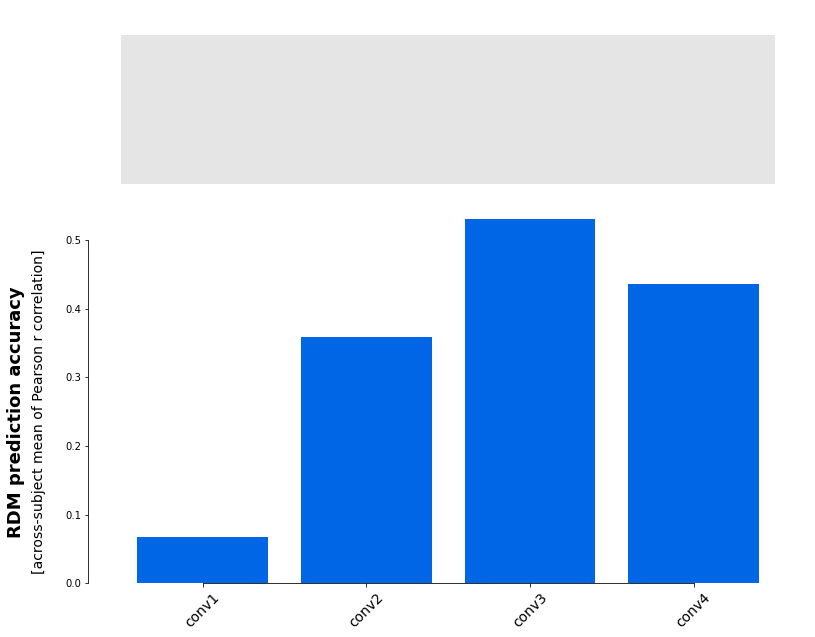

In [6]:
model_family = ModelFamily(models[0:4])

results = rsatoolbox.inference.crossval(models[0:4], rdms_data, train_set, test_set,
                                        ceil_set=ceil_set, method='corr')
# plot results
rsatoolbox.vis.plot_model_comparison(results, test_type=None, error_bars=None)

### Evaluate model family and plot bars for each family member

/Users/heiko/rsatoolbox/rsatoolbox/vis/model_plot.py:154: UserWarning: tests deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('tests deactivated as crossvalidation does not'
/Users/heiko/rsatoolbox/rsatoolbox/vis/model_plot.py:160: UserWarning: errorbars deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('errorbars deactivated as crossvalidation does not'


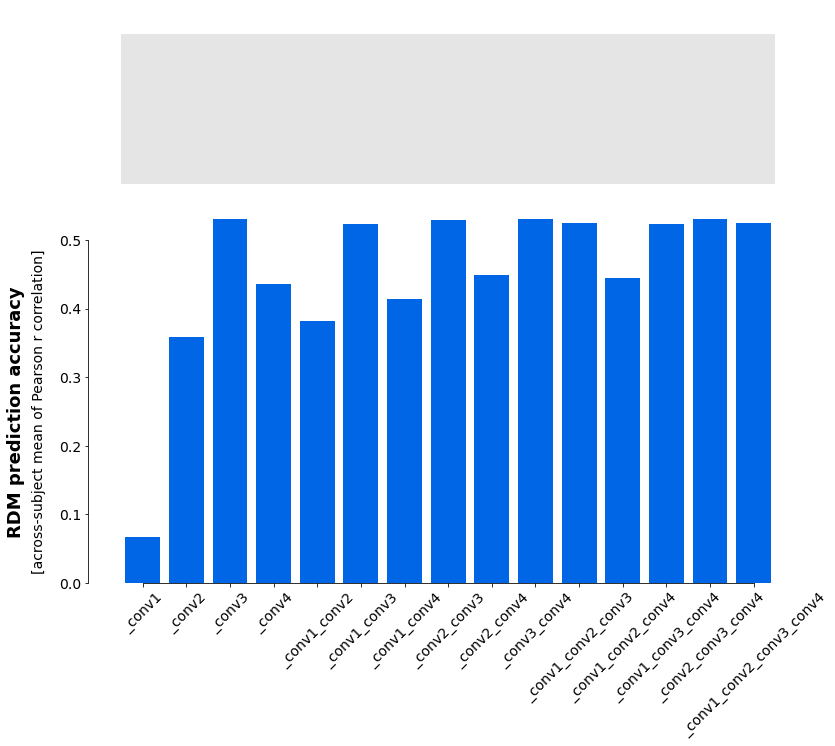

In [7]:
results = rsatoolbox.inference.crossval(model_family.get_all_family_members(), rdms_data, train_set, test_set,
                                        ceil_set=ceil_set, method='corr')
# plot results
rsatoolbox.vis.plot_model_comparison(results)

### visualizing family graph
We can visualize the above bar plot in a more convenient way using Graph where each node represents a family member.
1. Numbers inside the node represent which layers were selected in that family member. 
2. We can choose color/area of the node proportional to its performance. 
3. Edges are always directed towards increase in performance. 
4. The width of the edges indicates the improvement in performance when going from one node to other

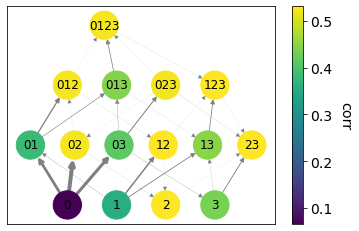

In [8]:
rsatoolbox.vis.show_family_graph(model_family, results, node_property="color")

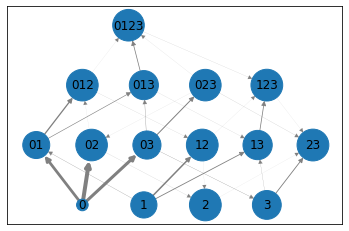

In [9]:
rsatoolbox.vis.show_family_graph(model_family, results, node_property="area")

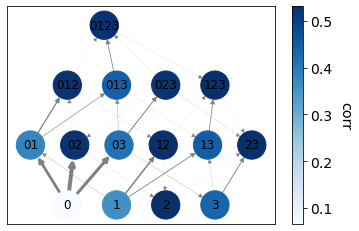

In [10]:
rsatoolbox.vis.show_family_graph(model_family, results, node_property="color", cmap=plt.cm.Blues)

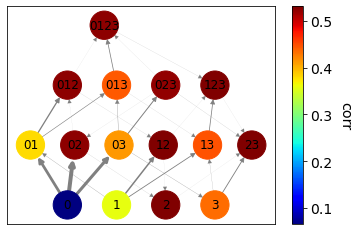

In [11]:
rsatoolbox.vis.show_family_graph(model_family, results, node_property="color", cmap=plt.cm.jet)

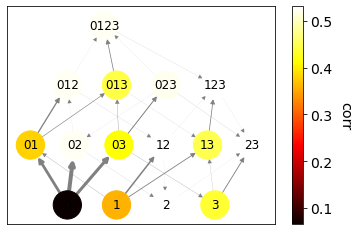

In [12]:
rsatoolbox.vis.show_family_graph(model_family, results, node_property="color", cmap=plt.cm.hot)

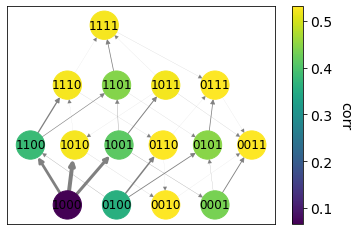

In [13]:
rsatoolbox.vis.show_family_graph(model_family, results, node_labels='binary', node_property="color")